In [1]:
import pandas as pd
import glob

In [2]:
files = glob.glob("../data/raw/epl_*.csv")

dfs = []
for f in files:
    df = pd.read_csv(f)
    df["Season"] = f.split("/")[-1].replace(".csv", "")
    dfs.append(df)


In [3]:
all_seasons = pd.concat(dfs, ignore_index=True)
all_seasons.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BMGMCA,BVCH,BVCD,BVCA,CLCH,CLCD,CLCA,LBCH,LBCD,LBCA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Create match-level points
all_seasons["HomePoints"] = all_seasons["FTR"].map({"H": 3, "D": 1, "A": 0})
all_seasons["AwayPoints"] = all_seasons["FTR"].map({"A": 3, "D": 1, "H": 0})

all_seasons[["HomeTeam", "AwayTeam", "HomePoints", "AwayPoints"]].head()

#Converts results (H / D / A) into numeric points
#Still match-level (one row = one game)

/var/folders/rj/k473m8nd7d7gy_mpf21cph0c0000gn/T/ipykernel_23141/2065478006.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_seasons["HomePoints"] = all_seasons["FTR"].map({"H": 3, "D": 1, "A": 0})
/var/folders/rj/k473m8nd7d7gy_mpf21cph0c0000gn/T/ipykernel_23141/2065478006.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_seasons["AwayPoints"] = all_seasons["FTR"].map({"A": 3, "D": 1, "H": 0})


,HomeTeam,AwayTeam,HomePoints,AwayPoints
0,Burnley,Man City,0,3
1,Arsenal,Nott'm Forest,3,0
2,Bournemouth,West Ham,1,1
3,Brighton,Luton,3,0
4,Everton,Fulham,0,3


In [5]:
# Home stats
home = (
    all_seasons
    .groupby(["Season", "HomeTeam"])
    .agg(
        matches_home=("HomeTeam", "count"),
        goals_for_home=("FTHG", "sum"),
        goals_against_home=("FTAG", "sum"),
        points_home=("HomePoints", "sum"),
    )
    .reset_index()
    .rename(columns={"HomeTeam": "Team"})
)

# Away stats
away = (
    all_seasons
    .groupby(["Season", "AwayTeam"])
    .agg(
        matches_away=("AwayTeam", "count"),
        goals_for_away=("FTAG", "sum"),
        goals_against_away=("FTHG", "sum"),
        points_away=("AwayPoints", "sum"),
    )
    .reset_index()
    .rename(columns={"AwayTeam": "Team"})
)

# Combine home + away
season_table = (
    home.merge(away, on=["Season", "Team"], how="outer")
)

# Final totals
season_table["Matches"] = season_table["matches_home"] + season_table["matches_away"]
season_table["GoalsFor"] = season_table["goals_for_home"] + season_table["goals_for_away"]
season_table["GoalsAgainst"] = season_table["goals_against_home"] + season_table["goals_against_away"]
season_table["Points"] = season_table["points_home"] + season_table["points_away"]

season_table[["Season", "Team", "Matches", "GoalsFor", "GoalsAgainst", "Points"]].head()


,Season,Team,Matches,GoalsFor,GoalsAgainst,Points
0,epl_2019_2020,Arsenal,38,56,48,56
1,epl_2019_2020,Aston Villa,38,41,67,35
2,epl_2019_2020,Bournemouth,38,40,65,34
3,epl_2019_2020,Brighton,38,39,54,41
4,epl_2019_2020,Burnley,38,43,50,54


In [6]:
season_table["Season"].unique()


array(['epl_2019_2020', 'epl_2020_2021', 'epl_2021_2022', 'epl_2022_2023',
       'epl_2023_2024', 'epl_2024_2025', 'epl_2025_26_curr'], dtype=object)

In [ ]:
SEASON = "epl_2024_2025"  # <-- change this to whichever season in raw
#liverpool won the league in 19/20 and 24/25
table = (
    season_table[season_table["Season"] == SEASON]
    .assign(GD=lambda d: d["GoalsFor"] - d["GoalsAgainst"])
    .sort_values(["Points", "GD", "GoalsFor"], ascending=False)
    .reset_index(drop=True)
)

# add rank
table.insert(0, "Rank", table.index + 1)

table[["Rank", "Team", "Matches", "Points", "GD", "GoalsFor", "GoalsAgainst"]].head(20)


,Rank,Team,Matches,Points,GD,GoalsFor,GoalsAgainst
0,1,Liverpool,38,84,45,86,41
1,2,Arsenal,38,74,35,69,34
2,3,Man City,38,71,28,72,44
3,4,Chelsea,38,69,21,64,43
4,5,Newcastle,38,66,21,68,47
5,6,Aston Villa,38,66,7,58,51
6,7,Nott'm Forest,38,65,12,58,46
7,8,Brighton,38,61,7,66,59
8,9,Bournemouth,38,56,12,58,46
9,10,Brentford,38,56,9,66,57


In [10]:
# How many teams per season?
season_table.groupby("Season")["Team"].nunique()


Season
epl_2019_2020       20
epl_2020_2021       20
epl_2021_2022       20
epl_2022_2023       20
epl_2023_2024       20
epl_2024_2025       20
epl_2025_26_curr    20
Name: Team, dtype: int64

In [11]:
# Matches per team distribution in a season
season_table[season_table["Season"] == SEASON]["Matches"].describe()


count    20.0
mean     38.0
std       0.0
min      38.0
25%      38.0
50%      38.0
75%      38.0
max      38.0
Name: Matches, dtype: float64

Matplotlib is building the font cache; this may take a moment.


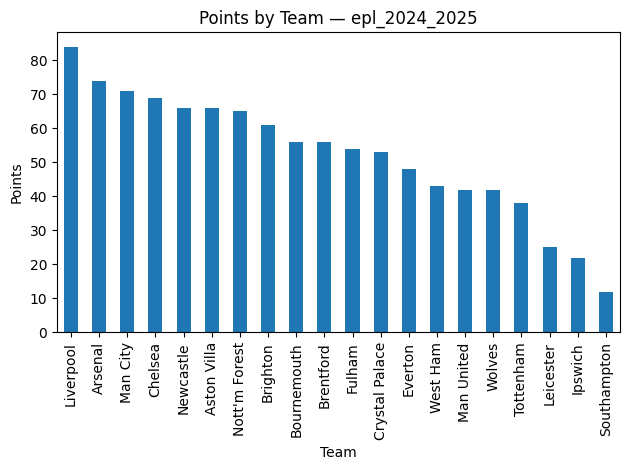

In [12]:
import matplotlib.pyplot as plt

plt.figure()
table.set_index("Team")["Points"].plot(kind="bar")
plt.title(f"Points by Team — {SEASON}")
plt.ylabel("Points")
plt.tight_layout()
plt.show()


BASELINE MODEL : POINTS PREDICTION
One team per row
Features: goals scored and conceded
Target: total points
model: Linear Regression

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Features and target
X = season_table[["GoalsFor", "GoalsAgainst"]]
y = season_table["Points"]

X.head(), y.head()


(   GoalsFor  GoalsAgainst
 0        56            48
 1        41            67
 2        40            65
 3        39            54
 4        43            50,
 0    56
 1    35
 2    34
 3    41
 4    54
 Name: Points, dtype: int64)

In [ ]:
#train/test split (by season logic)
TEST_SEASON = "epl_2024_2025"

train = season_table[season_table["Season"] != TEST_SEASON]
test = season_table[season_table["Season"] == TEST_SEASON]

X_train = train[["GoalsFor", "GoalsAgainst"]]
y_train = train["Points"]

X_test = test[["GoalsFor", "GoalsAgainst"]]
y_test = test["Points"]

len(train), len(test)


(120, 20)

In [16]:
#train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [ ]:
#Performance evaluation
y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2


(4.629571189116389, 0.8783627037662171)

How to interpret this

MAE ≈ average error in points

MAE ≈ 4–6 → solid baseline

R² closer to 1 → better

0.7+ is good for sports data

Don’t panic if it’s imperfect — football is noisy.

In [18]:
#Compare pred vs actual
comparison = test.copy()
comparison["PredictedPoints"] = y_pred
comparison["Error"] = comparison["PredictedPoints"] - comparison["Points"]

comparison = (
    comparison
    .assign(GD=lambda d: d["GoalsFor"] - d["GoalsAgainst"])
    .sort_values("Points", ascending=False)
)

comparison[["Team", "Points", "PredictedPoints", "Error"]]


,Team,Points,PredictedPoints,Error
111,Liverpool,84,81.994636,-2.005364
100,Arsenal,74,69.115616,-4.884384
112,Man City,71,69.134493,-1.865507
105,Chelsea,69,62.483832,-6.516168
114,Newcastle,66,64.909119,-1.090881
101,Aston Villa,66,55.245727,-10.754273
115,Nott'm Forest,65,56.531504,-8.468496
104,Brighton,61,60.096299,-0.903701
102,Bournemouth,56,56.531504,0.531504
103,Brentford,56,60.610610,4.610610


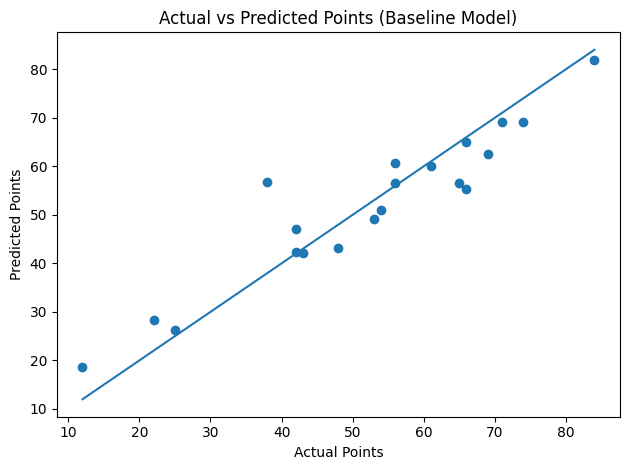

In [19]:
#Visual Sanity Check
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Actual vs Predicted Points (Baseline Model)")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.tight_layout()
plt.show()


3 ACTUAL FORM FEATURES
Inlude last 5 match points
last 5 goals in favor and against
H and A form
Teams performance aint static across seasons real time circumstances affect this. 

⚠️ Important modeling rule

We must never leak future information.

That means:

When computing “last 5 matches” for match t,

We only use matches before t, never after.

Pandas rolling windows handle this correctly when done right.

In [20]:
#3 back to match level data
matches = all_seasons.copy()

# Ensure matches are ordered in time
matches["Date"] = pd.to_datetime(matches["Date"], dayfirst=True)
matches = matches.sort_values(["Season", "Date"])


In [21]:
#long team-match table

home_rows = matches[[
    "Season", "Date", "HomeTeam", "FTHG", "FTAG", "HomePoints"
]].rename(columns={
    "HomeTeam": "Team",
    "FTHG": "GoalsFor",
    "FTAG": "GoalsAgainst",
    "HomePoints": "Points"
})

away_rows = matches[[
    "Season", "Date", "AwayTeam", "FTAG", "FTHG", "AwayPoints"
]].rename(columns={
    "AwayTeam": "Team",
    "FTAG": "GoalsFor",
    "FTHG": "GoalsAgainst",
    "AwayPoints": "Points"
})

team_matches = pd.concat([home_rows, away_rows], ignore_index=True)
team_matches = team_matches.sort_values(["Season", "Team", "Date"])

team_matches.head()


,Season,Date,Team,GoalsFor,GoalsAgainst,Points
2508,epl_2019_2020,2019-08-11,Arsenal,1,0,3
10,epl_2019_2020,2019-08-17,Arsenal,2,1,3
2526,epl_2019_2020,2019-08-24,Arsenal,1,3,0
39,epl_2019_2020,2019-09-01,Arsenal,2,2,1
2548,epl_2019_2020,2019-09-15,Arsenal,2,2,1


In [ ]:
#3.3 compute rolling last 5 features.... Extremeley importatnt to keep this correct
team_matches["Points_Last5"] = (
    team_matches
    .groupby(["Season", "Team"])["Points"]
    .transform(lambda x: x.shift().rolling(5, min_periods=1).sum())
)

team_matches["GF_Last5"] = (
    team_matches
    .groupby(["Season", "Team"])["GoalsFor"]
    .transform(lambda x: x.shift().rolling(5, min_periods=1).sum())
)

team_matches["GA_Last5"] = (
    team_matches
    .groupby(["Season", "Team"])["GoalsAgainst"]
    .transform(lambda x: x.shift().rolling(5, min_periods=1).sum())
)

team_matches.head(10)

#Why shift() matters

# shift() removes the current match

# Ensures features only use past matches

# This avoids data leakage (very important in interviews)

,Season,Date,Team,GoalsFor,GoalsAgainst,Points,Points_Last5,GF_Last5,GA_Last5
2508,epl_2019_2020,2019-08-11,Arsenal,1,0,3,NaN,NaN,NaN
10,epl_2019_2020,2019-08-17,Arsenal,2,1,3,3.0,1.0,0.0
2526,epl_2019_2020,2019-08-24,Arsenal,1,3,0,6.0,3.0,1.0
39,epl_2019_2020,2019-09-01,Arsenal,2,2,1,6.0,4.0,4.0
2548,epl_2019_2020,2019-09-15,Arsenal,2,2,1,7.0,6.0,6.0
58,epl_2019_2020,2019-09-22,Arsenal,3,2,3,8.0,8.0,8.0
2569,epl_2019_2020,2019-09-30,Arsenal,1,1,1,8.0,10.0,10.0
76,epl_2019_2020,2019-10-06,Arsenal,1,0,3,6.0,9.0,10.0
2589,epl_2019_2020,2019-10-21,Arsenal,0,1,0,9.0,9.0,7.0
97,epl_2019_2020,2019-10-27,Arsenal,2,2,1,8.0,7.0,6.0


In [23]:
#Step 3.4: Aggregate rolling features to season level

# Now we convert match-level rolling features → season-level averages.


rolling_season = (
    team_matches
    .groupby(["Season", "Team"])
    .agg(
        AvgPointsLast5=("Points_Last5", "mean"),
        AvgGFLast5=("GF_Last5", "mean"),
        AvgGALast5=("GA_Last5", "mean"),
    )
    .reset_index()
)

rolling_season.head()


,Season,Team,AvgPointsLast5,AvgGFLast5,AvgGALast5
0,epl_2019_2020,Arsenal,6.891892,6.918919,5.891892
1,epl_2019_2020,Aston Villa,4.027027,5.108108,8.756757
2,epl_2019_2020,Bournemouth,4.000000,4.702703,8.216216
3,epl_2019_2020,Brighton,4.945946,4.891892,6.729730
4,epl_2019_2020,Burnley,6.756757,5.297297,6.351351


In [24]:
#merge w/ season tbl... we will have statis season stats and dynamic form stats.
model_data = season_table.merge(
    rolling_season,
    on=["Season", "Team"],
    how="left"
)

model_data.head()



,Season,Team,matches_home,goals_for_home,goals_against_home,points_home,matches_away,goals_for_away,goals_against_away,points_away,Matches,GoalsFor,GoalsAgainst,Points,AvgPointsLast5,AvgGFLast5,AvgGALast5
0,epl_2019_2020,Arsenal,19,36,24,36,19,20,24,20,38,56,48,56,6.891892,6.918919,5.891892
1,epl_2019_2020,Aston Villa,19,22,30,24,19,19,37,11,38,41,67,35,4.027027,5.108108,8.756757
2,epl_2019_2020,Bournemouth,19,22,30,21,19,18,35,13,38,40,65,34,4.000000,4.702703,8.216216
3,epl_2019_2020,Brighton,19,20,27,22,19,19,27,19,38,39,54,41,4.945946,4.891892,6.729730
4,epl_2019_2020,Burnley,19,24,23,28,19,19,27,26,38,43,50,54,6.756757,5.297297,6.351351


In [25]:
#3.6 train improved model
FEATURES = [
    "GoalsFor",
    "GoalsAgainst",
    "AvgPointsLast5",
    "AvgGFLast5",
    "AvgGALast5",
]

train = model_data[model_data["Season"] != TEST_SEASON]
test = model_data[model_data["Season"] == TEST_SEASON]

X_train = train[FEATURES]
y_train = train["Points"]

X_test = test[FEATURES]
y_test = test["Points"]

model2 = LinearRegression()
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)

mean_absolute_error(y_test, y_pred2), r2_score(y_test, y_pred2)


(1.2482450649174794, 0.9909132973836547)

interpretation:
mean absolute error being 1.25  means my model is off by a point over an entire season.
R squared being 99% means any variation can be explained by features makes sense because form is very indicative of a teams peformance. 